# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [148]:
# import libraries
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#! pip install pyspark
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf, col, concat, count, lit, avg, lag, first, last, when, desc, asc, countDistinct, when, isnan
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround

from pyspark.sql.types import IntegerType, FloatType, DateType, TimestampType, StringType

from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler

from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LinearSVC, LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

from pyspark.ml.regression import LinearRegression


%matplotlib inline

In [149]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("Sparkify") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [150]:
path = "mini_sparkify_event_data.json"
sparkify_events = spark.read.json(path)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [151]:
sparkify_events.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [152]:
print("The number of rows is", sparkify_events.count())
print("The number of columns is", len(sparkify_events.columns))

The number of rows is 286500
The number of columns is 18


In [153]:
# Check the unique values of some categories to have an idea of the data
for col in ['auth', 'gender', 'location', 'level', 'method', 'page', 'status', 'registration']:
    print(sparkify_events.groupby(col).count().show(30))

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+

None
+------+------+
|gender| count|
+------+------+
|     F|154578|
|  null|  8346|
|     M|123576|
+------+------+

None
+--------------------+-----+
|            location|count|
+--------------------+-----+
|     Gainesville, FL| 1229|
|Atlantic City-Ham...| 2176|
|Deltona-Daytona B...|   73|
|San Diego-Carlsba...|  754|
|Cleveland-Elyria, OH| 1392|
|Kingsport-Bristol...| 1863|
|New Haven-Milford...| 4007|
|Birmingham-Hoover...|   75|
|  Corpus Christi, TX|   11|
|         Dubuque, IA|  651|
|Las Vegas-Henders...| 2042|
|Indianapolis-Carm...|  970|
|Seattle-Tacoma-Be...|  246|
|          Albany, OR|   23|
|   Winston-Salem, NC|  819|
|     Bakersfield, CA| 1775|
|Los Angeles-Long ...|30131|
|Minneapolis-St. P...| 2134|
|San Francisco-Oak...| 2647|
|Phoenix-Mesa-Scot...| 4846|
|Allentown-Bethleh...|  815|
|Miami-Fort Lauder..

In [154]:
# Print first 2 lines of 'sparkify_events'
sparkify_events.show(n=2, truncate=False, vertical=True)

-RECORD 0------------------------------------------------------------------------------------------------------------------------
 artist        | Martha Tilston                                                                                                  
 auth          | Logged In                                                                                                       
 firstName     | Colin                                                                                                           
 gender        | M                                                                                                               
 itemInSession | 50                                                                                                              
 lastName      | Freeman                                                                                                         
 length        | 277.89016                                                                

### Clean Data

#### Missing values

In [155]:
# Check columns with NaN values
for value in sparkify_events.columns:
    print ("In column (",value,") the number of missing values is", sparkify_events.where(sparkify_events[value].isNull()).count())

In column ( artist ) the number of missing values is 58392
In column ( auth ) the number of missing values is 0
In column ( firstName ) the number of missing values is 8346
In column ( gender ) the number of missing values is 8346
In column ( itemInSession ) the number of missing values is 0
In column ( lastName ) the number of missing values is 8346
In column ( length ) the number of missing values is 58392
In column ( level ) the number of missing values is 0
In column ( location ) the number of missing values is 8346
In column ( method ) the number of missing values is 0
In column ( page ) the number of missing values is 0
In column ( registration ) the number of missing values is 8346
In column ( sessionId ) the number of missing values is 0
In column ( song ) the number of missing values is 58392
In column ( status ) the number of missing values is 0
In column ( ts ) the number of missing values is 0
In column ( userAgent ) the number of missing values is 8346
In column ( userId )

#### Empty values

In [156]:
# Check columns with empty values
for value in sparkify_events.columns:
    print ("In column (",value,") the number of empty values is", sparkify_events.filter(sparkify_events[value] == '').count())

In column ( artist ) the number of empty values is 0
In column ( auth ) the number of empty values is 0
In column ( firstName ) the number of empty values is 0
In column ( gender ) the number of empty values is 0
In column ( itemInSession ) the number of empty values is 0
In column ( lastName ) the number of empty values is 0
In column ( length ) the number of empty values is 0
In column ( level ) the number of empty values is 0
In column ( location ) the number of empty values is 0
In column ( method ) the number of empty values is 0
In column ( page ) the number of empty values is 0
In column ( registration ) the number of empty values is 0
In column ( sessionId ) the number of empty values is 0
In column ( song ) the number of empty values is 0
In column ( status ) the number of empty values is 0
In column ( ts ) the number of empty values is 0
In column ( userAgent ) the number of empty values is 0
In column ( userId ) the number of empty values is 8346


In [383]:
# Delete columns with empty userid
sparkify_events = sparkify_events.filter(sparkify_events.userId != "")

In [384]:
# Check columns with empty values
for value in sparkify_events.columns:
    print ("In column (",value,") the number of empty values is", sparkify_events.filter(sparkify_events[value] == '').count())

In column ( artist ) the number of empty values is 0
In column ( auth ) the number of empty values is 0
In column ( firstName ) the number of empty values is 0
In column ( gender ) the number of empty values is 0
In column ( itemInSession ) the number of empty values is 0
In column ( lastName ) the number of empty values is 0
In column ( length ) the number of empty values is 0
In column ( level ) the number of empty values is 0
In column ( location ) the number of empty values is 0
In column ( method ) the number of empty values is 0
In column ( page ) the number of empty values is 0
In column ( registration ) the number of empty values is 0
In column ( sessionId ) the number of empty values is 0
In column ( song ) the number of empty values is 0
In column ( status ) the number of empty values is 0
In column ( ts ) the number of empty values is 0
In column ( userAgent ) the number of empty values is 0
In column ( userId ) the number of empty values is 0
In column ( churn ) the number 

We got rid of the userId rows that were empty. Now let's take a look at the NaN values

In [159]:
# Check columns with NaN values
for value in sparkify_events.columns:
    print ("In column (",value,") the number of missing values is", sparkify_events.where(sparkify_events[value].isNull()).count())

In column ( artist ) the number of missing values is 50046
In column ( auth ) the number of missing values is 0
In column ( firstName ) the number of missing values is 0
In column ( gender ) the number of missing values is 0
In column ( itemInSession ) the number of missing values is 0
In column ( lastName ) the number of missing values is 0
In column ( length ) the number of missing values is 50046
In column ( level ) the number of missing values is 0
In column ( location ) the number of missing values is 0
In column ( method ) the number of missing values is 0
In column ( page ) the number of missing values is 0
In column ( registration ) the number of missing values is 0
In column ( sessionId ) the number of missing values is 0
In column ( song ) the number of missing values is 50046
In column ( status ) the number of missing values is 0
In column ( ts ) the number of missing values is 0
In column ( userAgent ) the number of missing values is 0
In column ( userId ) the number of mis

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

#### Cancellation Confirmation

In [160]:
# Flag definition for churn (Cancellation Confirmation)
churn_flag = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
sparkify_events = sparkify_events.withColumn("churn", churn_flag("page"))

# Apply churn flag to dataset
window_val = Window.partitionBy("userId")
sparkify_events = sparkify_events.withColumn("churn", Fsum("churn").over(window_val))

In [161]:
# Churned users
sparkify_events["userId", "churn"].dropDuplicates().groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



#### Downgrade Events

In [162]:
# Flag definition for churn (Downgrade)
churn_downgrade = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())
sparkify_events = sparkify_events.withColumn("downgrade", churn_downgrade("page"))

# Apply churn flag to dataset
windowval_val = Window.partitionBy("userId")
sparkify_events = sparkify_events.withColumn("downgrade", Fsum("downgrade").over(windowval_val))

In [163]:
# Downgraded users
sparkify_events["userId", "downgrade"].dropDuplicates().groupby("downgrade").count().show()

+---------+-----+
|downgrade|count|
+---------+-----+
|       26|    2|
|       19|    2|
|        0|   71|
|       22|    5|
|        7|    4|
|       50|    1|
|       32|    2|
|       31|    1|
|       39|    1|
|       25|    2|
|        6|    9|
|       68|    1|
|        9|   11|
|       27|    1|
|       17|    2|
|       41|    2|
|       28|    2|
|        5|   12|
|        1|    6|
|       10|    8|
+---------+-----+
only showing top 20 rows



### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Churn by gender
We will start taking a look at the churn rate by gender

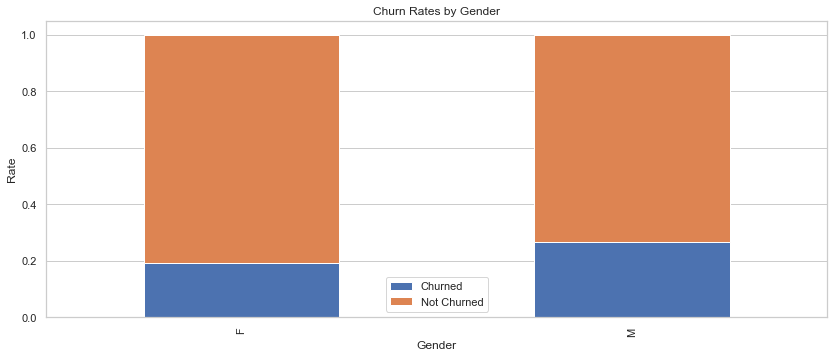

In [233]:
# Churn by Gender
churn_g = sparkify_events.groupby('gender', 'churn').agg(countDistinct('userId')).toPandas().\
          rename(columns = {'count(userId)':'n_users'}).pivot(index = 'gender', columns = 'churn', values = 'n_users').\
          rename(columns = {0:'Not Churned', 1:'Churned'})

churn_g['All']= churn_g['Not Churned'] + churn_g['Churned']
churn_g['Churned'] = churn_g['Churned'] / churn_g['All']
churn_g['Not Churned'] = 1 - churn_g['Churned']

fig = plt.figure(figsize = (14, 12))
ax1 = fig.add_subplot(2,1,2)
churn_g[['Churned','Not Churned']].plot(kind = 'bar', ax = ax1, stacked = True)
plt.title('Churn Rates by Gender')
plt.ylabel("Rate")
plt.xlabel("Gender")
plt.legend(loc = 'best')
plt.grid(axis='x')

It seems that Male users have a slightly more tendency to cancel their subscription

#### Page events
Now we will take a look at the number of "page" events registered in the dataset

Text(0.5, 0, 'Number of interactions')

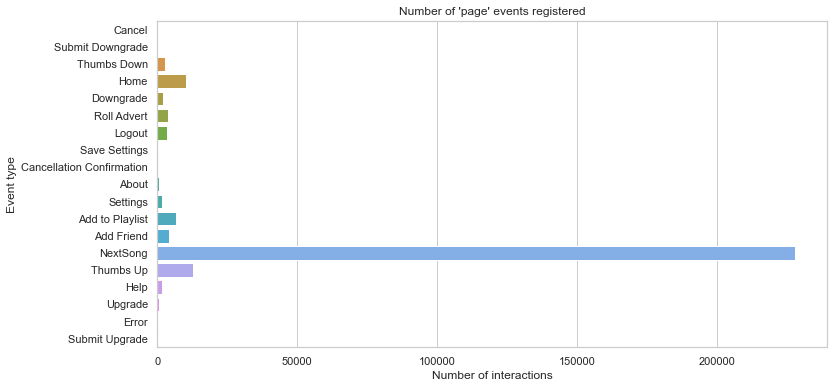

In [208]:
# Number of "page" events registered
data = sparkify_events.groupby("page").count().alias("count").toPandas()
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x="count", y="page", data=data)
ax.set_title("Number of 'page' events registered")
ax.set_ylabel("Event type")
ax.set_xlabel("Number of interactions")

Text(0.5, 0, 'Number of interactions')

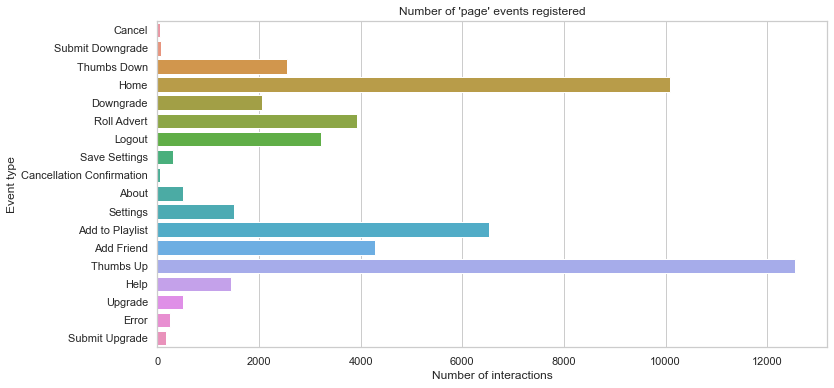

In [211]:
# Number of "page" events registered without 'NextSong'
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x="count", y="page", data=data[data.page!='NextSong'])
ax.set_title("Number of 'page' events registered")
ax.set_ylabel("Event type")
ax.set_xlabel("Number of interactions")

As expected in a music service, "NextSong" event is the one with the most interactions

#### Days passed until Cancellation Confirmation
Let's calculate the days that users take to submit a Cancellation Confirmation event

In [290]:
# Filter to users that have confirmed the cancellation
cancel_sparkify_date = sparkify_events[sparkify_events['page'] == 'Cancellation Confirmation'].toPandas()

# Take the columns we are interested in
cancel_sparkify_date = cancel_sparkify_date[["ts","registration"]]

# Convert the columns dividing by 1000 first
cancel_sparkify_date['ts'] = cancel_sparkify_date['ts'].apply(lambda x: datetime.datetime.fromtimestamp(x / 1000.0))
cancel_sparkify_date['registration'] = cancel_sparkify_date['registration'].apply(lambda x: datetime.datetime.fromtimestamp(x / 1000.0))

# Substract the time they cancelled to the time they registered
cancel_sparkify_date['diff_days'] = cancel_sparkify_date['ts'] - cancel_sparkify_date['registration']
cancel_sparkify_date['diff_days'] = cancel_sparkify_date['diff_days'] / np.timedelta64(1,'D')

In [291]:
# Average and median days until user cancels the service
print("Average days that users take until they cancel the music service:", cancel_sparkify_date["diff_days"].mean())
print("Median days that users take until they cancel the music service:", cancel_sparkify_date["diff_days"].median())

Average days that users take until they cancel the music service: 57.28756343482909
Median days that users take until they cancel the music service: 51.28939236111111


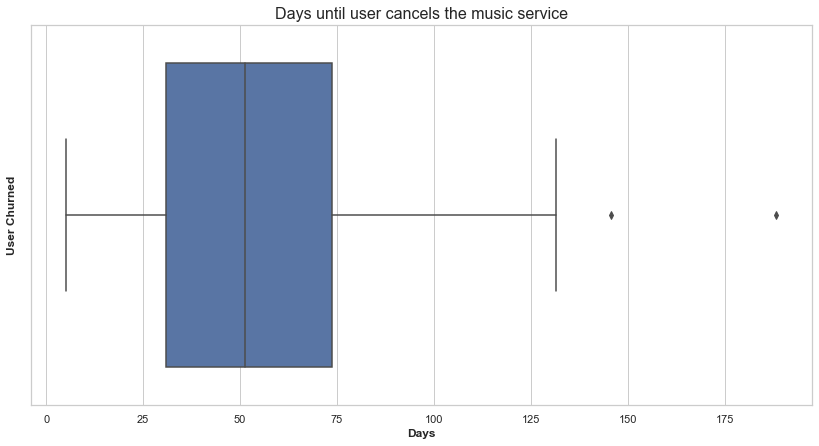

In [299]:
# Average days until user cancels the service
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")
ax = sns.boxplot(x='diff_days', orient="h", data=cancel_sparkify_date)
ax.set_title("Days until user cancels the music service", fontsize=16)
ax.set_xlabel("Days", fontsize=12, weight='bold')
ax.set_ylabel("User Churned", fontsize=12, weight='bold');

Let's create a function for drawing boxplots

In [276]:
def draw_boxplot(title = "Thumbs Up per sessionId between users that churned and not",\
                 xlabel = "Number of 'Thumbs Up'", ylabel = "Churn", style="whitegrid", x_data = "count",\
                 y_data = "churn", orientation = "h", df = data):
    '''
    INPUT:
    title - the title of the plot
    xlabel - the name of the x axis
    ylabel - the name of the y axis
    style - style of the plot
    x_data - column to plot in x axis
    y_data - column to plot in y axis
    orientation - select if the boxplot is horizontal or vertical
    df - dataframe with the data
    OUTPUT:
    Boxplot of the data
    
    Takes a dataframe a draw a boxplot of the desired columns
    '''
    plt.figure(figsize=(14, 7))
    sns.set_style(style)
    ax = sns.boxplot(x=x_data, y=y_data, orient=orientation, data=df)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=12, weight='bold')
    ax.set_ylabel(ylabel, fontsize=12, weight='bold')

#### 'Thumbs up' interactions

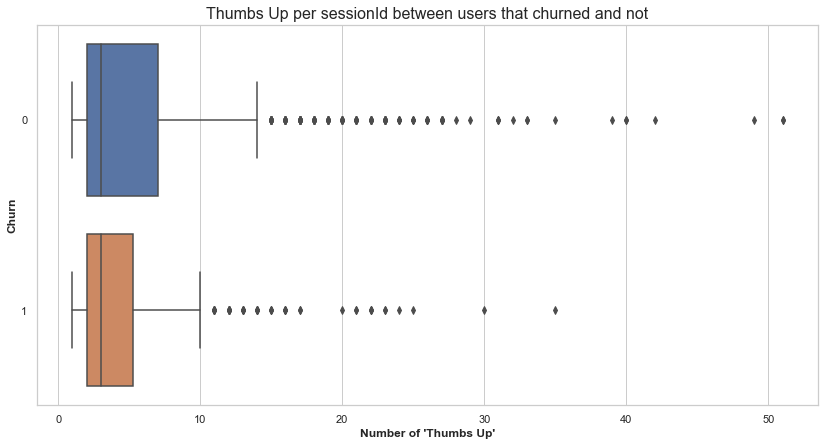

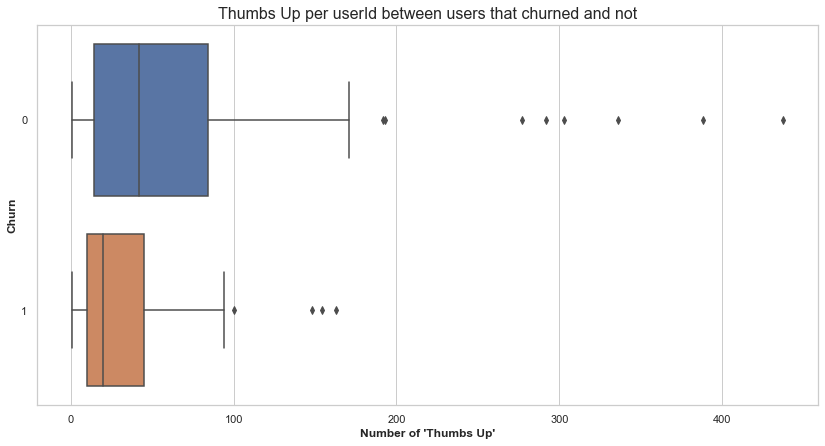

In [286]:
# Thumbs Up per sessionId and churn
data = sparkify_events.filter(sparkify_events['page'] == 'Thumbs Up').groupby("userId", "churn", "sessionId").count().toPandas()
draw_boxplot("Thumbs Up per sessionId between users that churned and not", "Number of 'Thumbs Up'",\
             "Churn", "whitegrid", "count", "churn", "h", data)

# Thumbs Up per userId and churn
data = sparkify_events.filter(sparkify_events['page'] == 'Thumbs Up').groupby("userId", "churn",).count().toPandas()
draw_boxplot("Thumbs Up per userId between users that churned and not", "Number of 'Thumbs Up'",\
             "Churn", "whitegrid", "count", "churn", "h", data)

#### 'Add Friend' interactions

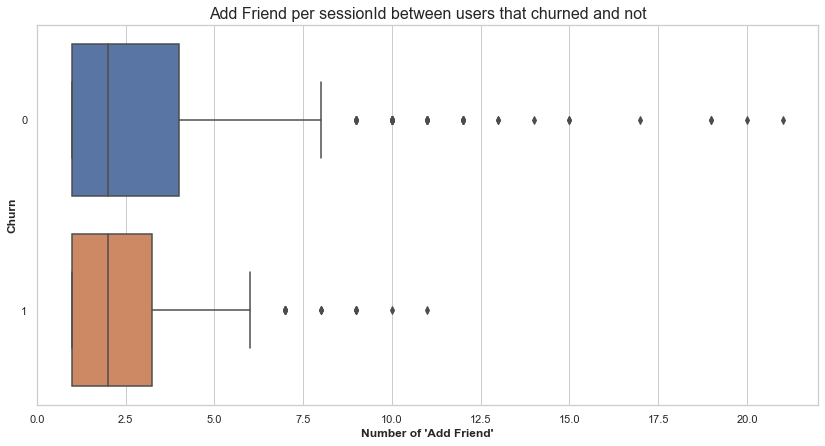

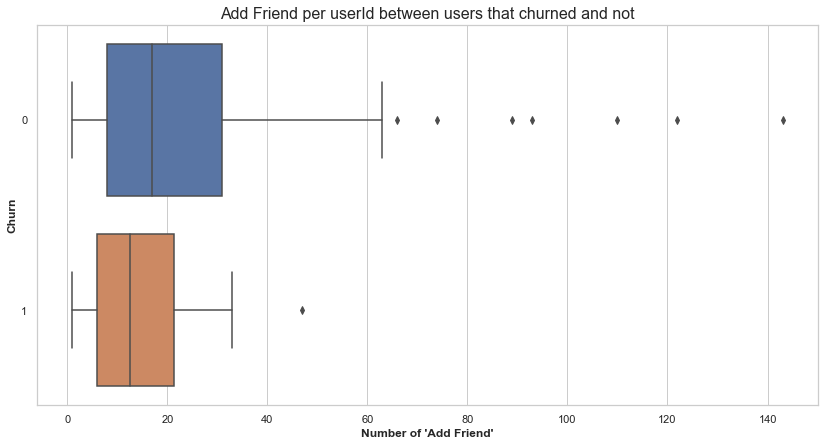

In [287]:
# Add Friend per sessionId and churn
data = sparkify_events.filter(sparkify_events['page'] == 'Add Friend').groupby("userId", "churn", "sessionId").count().toPandas()
draw_boxplot("Add Friend per sessionId between users that churned and not", "Number of 'Add Friend'",\
             "Churn", "whitegrid", "count", "churn", "h", data)

# Add Friend per userId and churn
data = sparkify_events.filter(sparkify_events['page'] == 'Add Friend').groupby("userId", "churn").count().toPandas()
draw_boxplot("Add Friend per userId between users that churned and not", "Number of 'Add Friend'",\
             "Churn", "whitegrid", "count", "churn", "h", data)

#### 'Help' interactions

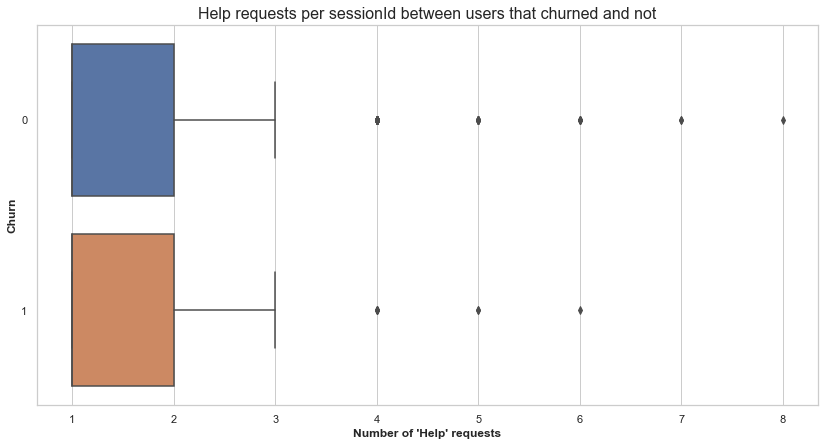

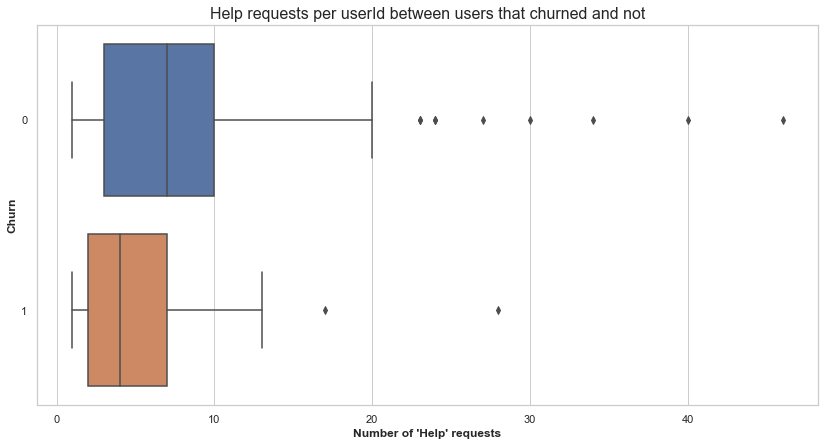

In [288]:
# Help requests per sessionId and churn
data = sparkify_events.filter(sparkify_events['page'] == 'Help').groupby("userId", "churn", "sessionId").count().toPandas()
draw_boxplot("Help requests per sessionId between users that churned and not", "Number of 'Help' requests",\
             "Churn", "whitegrid", "count", "churn", "h", data)

# Help requests per userId and churn
data = sparkify_events.filter(sparkify_events['page'] == 'Help').groupby("userId", "churn").count().toPandas()
draw_boxplot("Help requests per userId between users that churned and not", "Number of 'Help' requests",\
             "Churn", "whitegrid", "count", "churn", "h", data)

#### 'Next Song' interactions

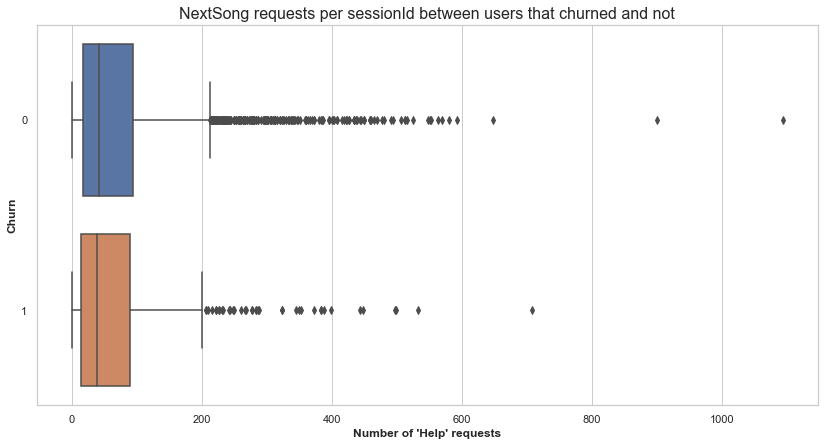

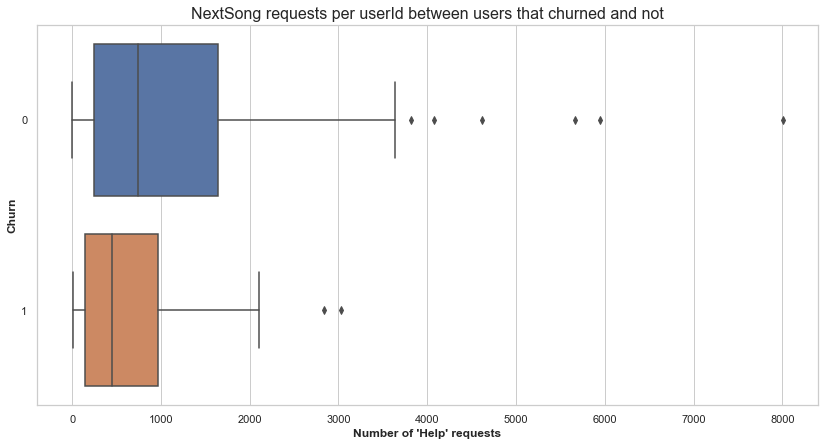

In [289]:
# Next Song per sessionId and churn
data = sparkify_events.filter(sparkify_events['page'] == 'NextSong').groupby("userId", "churn", "sessionId").count().toPandas()
draw_boxplot("NextSong requests per sessionId between users that churned and not", "Number of 'Help' requests",\
             "Churn", "whitegrid", "count", "churn", "h", data)

# Next Song per userId and churn
data = sparkify_events.filter(sparkify_events['page'] == 'NextSong').groupby("userId", "churn").count().toPandas()
draw_boxplot("NextSong requests per userId between users that churned and not", "Number of 'Help' requests",\
             "Churn", "whitegrid", "count", "churn", "h", data)

#### Churn by device

In [307]:
# User defined function to split the name of the device from the userAgent column
split_device = udf(lambda x: x.split('(')[1].split(';')[0].split(' ')[0])

# Add the column with the device used to sparkify_events
sparkify_events = sparkify_events.withColumn("device", split_device(sparkify_events.userAgent))

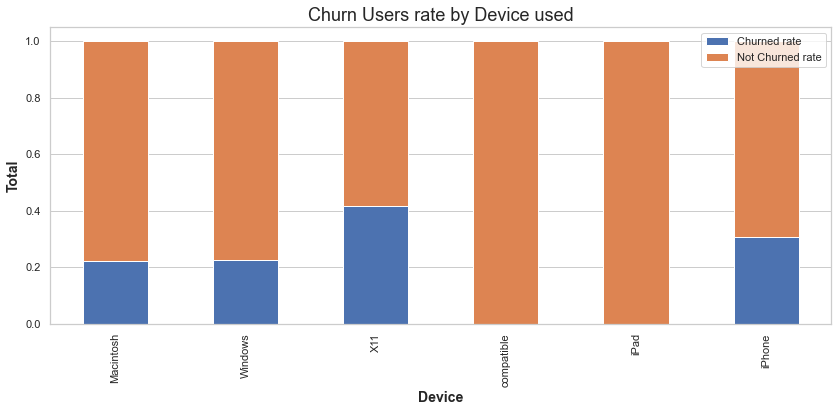

In [308]:
# Group by device and by churn and pivot the table
churn_by_dev = sparkify_events.groupby('device', 'churn').agg(countDistinct('userId')).toPandas()\
               .rename(columns = {'count(userId)':'n_users'}).pivot(index = 'device', \
               columns = 'churn', values = 'n_users').rename(columns = {0:'Not Churned', 1:'Churned'})

# Fill NaN values
churn_by_dev.fillna(0, inplace = True)

# Calculate rates
churn_by_dev['All']= churn_by_dev['Not Churned'] + churn_by_dev['Churned']
churn_by_dev['Churned rate'] = churn_by_dev['Churned'] / churn_by_dev['All']
churn_by_dev['Not Churned rate'] = 1 - churn_by_dev['Churned rate']

# Plot
fig = plt.figure(figsize = (14, 12))
ax1 = fig.add_subplot(2,1,1)
churn_by_dev[['Churned rate','Not Churned rate']].plot(kind = 'bar', ax = ax1, stacked = True)
plt.title('Churn Users rate by Device used', fontsize=18)
plt.ylabel("Total", fontsize=14, fontweight='bold')
plt.xlabel("Device", fontsize=14, fontweight='bold')
plt.legend(loc = 'best')
plt.grid(axis='x')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Features to be used

1. Listened songs 
2. Average played songs per session
3. Songs added to playlist
4. Total different artists listened
5. Average played time per session
5. Sessions of the user
7. Time passed since registration
8. Friends number
9. Thumbs up
10. Thumbs down
11. Help requests
12. Errors
13. Downgrade
14. Gender
15. Free or paid user
16. Churn

In [415]:
# 1. Listened songs
FE_listened_songs = sparkify_events.select('userID', 'page').where(sparkify_events.page == 'NextSong').groupBy('userID').\
                 count().withColumnRenamed('count', 'songs')

print("The number of rows in '1. Listened songs' is", FE_listened_songs.count())
print("The number of columns in '1. Listened songs' is", len(FE_listened_songs.columns))



# 2. Average played songs per session
FE_avg_songs_session = sparkify_events.where(sparkify_events.song.isNotNull()).groupby(['userId', 'sessionId']).count().\
                       groupby(['userId']).agg({'count': 'avg'}).withColumnRenamed('avg(count)', 'avg_songs_session')

print("The number of rows in '2. Average played songs per session' is", FE_avg_songs_session.count())
print("The number of columns in '2. Average played songs per session' is", len(FE_avg_songs_session.columns))



# 3. Songs added to playlist
FE_add_playlist = sparkify_events.select('userId', 'page').where(sparkify_events.page == 'Add to Playlist').\
                  groupBy('userId').count().withColumnRenamed('count', 'add_playlist')

print("The number of rows in '3. Songs added to playlist' is", FE_add_playlist.count())
print("The number of columns in '3. Songs added to playlist' is", len(FE_add_playlist.columns))



# 4. Total different artists listened
FE_dif_artists = sparkify_events.select("userId", "artist").dropDuplicates().groupby("userId").count().\
                 withColumnRenamed('count', 'dif_artists')

print("The number of rows in '4. Total different artists listened' is", FE_dif_artists.count())
print("The number of columns in '4. Total different artists listened' is", len(FE_dif_artists.columns))



# 5. Average played time per session
played_max = sparkify_events.groupBy('userId', 'sessionId').max('ts').withColumnRenamed('max(ts)', 'max')
played_min = sparkify_events.groupBy('userId', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'min')
played_session = played_min.join(played_max,['userId', 'sessionId'])
played_session = played_session.select('userId', 'sessionId', ((played_session.max-played_session.min)/(1000*60)).\
                 alias('played_session'))
# Average
FE_played_time_session = played_session.groupBy('userId').agg(avg('played_session').alias('played_time_session'))     
FE_played_time_session = FE_played_time_session.na.fill(0)

print("The number of rows in '5. Average played time per session' is", FE_played_time_session.count())
print("The number of columns in '5. Average played time per session' is", len(FE_played_time_session.columns))



# 6. Sessions of the user
FE_sessions_user = sparkify_events.select("userId", "sessionId").dropDuplicates().groupby("userId").count().\
                   withColumnRenamed('count', 'sessions_user')

print("The number of rows in '6. Sessions of the user' is", FE_sessions_user.count())
print("The number of columns in '6. Sessions of the user' is", len(FE_sessions_user.columns))



# 7. Time passed since registration
latest_time = sparkify_events.groupby("userId").max("ts").sort("userId")
sign_up_moment = sparkify_events.select("userId", "registration").dropDuplicates().sort("userId")
FE_time_since_registration = sign_up_moment.join(latest_time, sign_up_moment.userId == latest_time.userId).\
                             select(sign_up_moment["userId"], ((latest_time["max(ts)"]-sign_up_moment["registration"])/(1000*60)).\
                             alias("registration_min"))

print("The number of rows in '7. Time passed since registration' is", FE_time_since_registration.count())
print("The number of columns in '7. Time passed since registration' is", len(FE_time_since_registration.columns))



# 8. Friends number
FE_friends = sparkify_events.select('userId', 'page').where(sparkify_events.page == 'Add Friend').groupBy('userId').\
            count().withColumnRenamed('count', 'friend').sort('userId')

print("The number of rows in '8. Friends number' is", FE_friends.count())
print("The number of columns in '8. Friends number' is", len(FE_friends.columns))



# 9. Thumbs up
FE_thumbs_up = sparkify_events.select('userId', 'page').where(sparkify_events.page == 'Thumbs Up').groupBy('userId').\
            count().withColumnRenamed('count', 'thumbs_up')

print("The number of rows in '9. Thumbs up' is", FE_thumbs_up.count())
print("The number of columns in '9. Thumbs up' is", len(FE_thumbs_up.columns))



# 10. Thumbs down
FE_thumbs_down = sparkify_events.select('userId', 'page').where(sparkify_events.page == 'Thumbs Down').groupBy('userId').\
            count().withColumnRenamed('count', 'thumbs_down')

print("The number of rows in '10. Thumbs down' is", FE_thumbs_down.count())
print("The number of columns in '10. Thumbs down' is", len(FE_thumbs_down.columns))



# 11. Help requests
FE_help = sparkify_events.select('userId', 'page').where(sparkify_events.page == 'Help').groupBy('userId').\
            count().withColumnRenamed('count', 'help')

print("The number of rows in '11. Help requests' is", FE_help.count())
print("The number of columns in '11. Help requests' is", len(FE_help.columns))



# 12. Errors
FE_errors = sparkify_events.select('userId', 'page').where(sparkify_events.page == 'Error').groupBy('userId').\
            count().withColumnRenamed('count', 'errors')

print("The number of rows in '12. Errors' is", FE_errors.count())
print("The number of columns in '12. Errors' is", len(FE_errors.columns))



# 13. Downgrade
FE_downgrade = sparkify_events["userId", "downgrade"].dropDuplicates()

print("The number of rows in '13. Downgrade' is", FE_downgrade.count())
print("The number of columns in '13. Downgrade' is", len(FE_downgrade.columns))



# 14. Gender
FE_gender = sparkify_events.groupby('userId').agg(first(when(sparkify_events.gender == "F", 1).otherwise(0)).alias('gender'))

print("The number of rows in '14. Gender' is", FE_gender.count())
print("The number of columns in '14. Gender' is", len(FE_gender.columns))



# 15. Free or paid user
FE_level = sparkify_events.groupby('userId').agg(last(when(sparkify_events.level == 'paid', 1).otherwise(0)).\
           alias('level'))

print("The number of rows in '15. Free or paid user' is", FE_level.count())
print("The number of columns in '15. Free or paid user' is", len(FE_level.columns))



# 16. Churn
FE_churn = sparkify_events.select('userId', 'churn').dropDuplicates()

print("The number of rows in '16. Churn' is", FE_churn.count())
print("The number of columns in '16. Churn' is", len(FE_churn.columns))

The number of rows in '1. Listened songs' is 225
The number of columns in '1. Listened songs' is 2
The number of rows in '2. Average played songs per session' is 225
The number of columns in '2. Average played songs per session' is 2
The number of rows in '3. Songs added to playlist' is 215
The number of columns in '3. Songs added to playlist' is 2
The number of rows in '4. Total different artists listened' is 225
The number of columns in '4. Total different artists listened' is 2
The number of rows in '5. Average played time per session' is 225
The number of columns in '5. Average played time per session' is 2
The number of rows in '6. Sessions of the user' is 225
The number of columns in '6. Sessions of the user' is 2
The number of rows in '7. Time passed since registration' is 225
The number of columns in '7. Time passed since registration' is 2
The number of rows in '8. Friends number' is 206
The number of columns in '8. Friends number' is 2
The number of rows in '9. Thumbs up' is 

In [417]:
print("-> Starting Feature Engineering...")
start = datetime.datetime.now()
    
data = FE_listened_songs.join(FE_avg_songs_session,'userID','outer') \
    .join(FE_add_playlist,'userID','outer') \
    .join(FE_dif_artists,'userID','outer') \
    .join(FE_played_time_session,'userID','outer') \
    .join(FE_sessions_user,'userID','outer') \
    .join(FE_time_since_registration,'userID','outer') \
    .join(FE_friends,'userID','outer') \
    .join(FE_thumbs_up,'userID','outer') \
    .join(FE_thumbs_down,'userID','outer') \
    .join(FE_help,'userID','outer') \
    .join(FE_errors,'userID','outer') \
    .join(FE_downgrade,'userID','outer') \
    .join(FE_gender,'userID','outer') \
    .join(FE_level,'userID','outer') \
    .join(FE_churn,'userID','outer') \
    .drop('userID') \
    .fillna(0)

    
print ("-> Final dataframe with:",data.count(), "rows and ",len(data.dtypes),"columns")
print ("-> Duration:",datetime.datetime.now()-start,"s")
print ("-> Process finished")

-> Starting Feature Engineering...
-> Final dataframe with: 225 rows and  16 columns
-> Duration: 0:00:27.261919 s
-> Process finished


In [ ]:
def features():
    
    

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [235]:
# Function to split the date column
def split_date(df, column):
    '''
    INPUT:
    df - the dataframe that contains a column with date data to be split
    column - the name of the column have the date to be split
    OUTPUT:
    df[column+year/month/day/dayofweek] - new columns will be added to the dataframe with the date split
    
    Takes the date from the column specified and split it into year, month, day and dayofweek 
    and then this data is added to the existing input dataframe
    '''
    df[column+'_hour'] = df[column].apply(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
    df[column+'_day'] = df[column].apply(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
    df[column+'_dayofweek'] = df[column].apply(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
    
    
# date column split
sparkify_date = sparkify_events.toPandas()
split_date(sparkify_date, 'ts')

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.